Criado com base no artigo:

https://colab.research.google.com/github/sparsh-ai/rec-tutorials/blob/master/_notebooks/2021-04-27-image-similarity-recommendations.ipynb

In [2]:
# Conexão ao Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Chave de acesso ao Kaggle

#hide
%%writefile kaggle.json
{"username":"felipeanzolin","key":"ca3d129a0454ed1a7d3fc81655153414"}

Writing kaggle.json


In [4]:
# Instalação do Kaggle

#hide
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=cc17ae83211cc3e3e4b2115458c4e1f573b2a4032fe8cf2ec106e0cd1b7dbe22
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
# downloading raw images from kaggle
#!kaggle datasets download -d trolukovich/food11-image-dataset
#!unzip food11-image-dataset.zip

!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

In [6]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm
import shutil

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

# if not os.path.exists('/content/food_data'):
#     os.mkdir('/content/food_data')
# os.chdir('/content/food_data')

# if not os.path.exists('/content/food_data/categories'):
#     os.mkdir('/content/food_data/categories')

# path_from = '/content/training/Bread'
# path_to = '/content/food_data/categories/'
# move(path_from, path_to)

# path_from = '/content/training/Dairy product'
# move(path_from, path_to)

# path_from = '/content/training/Dessert'
# move(path_from, path_to)

# path_from = '/content/training/Egg'
# move(path_from, path_to)

# path_from = '/content/training/Fried food'
# move(path_from, path_to)

# path_from = '/content/training/Meat'
# move(path_from, path_to)

# path_from = '/content/training/Noodles-Pasta'
# move(path_from, path_to)

# path_from = '/content/training/Rice'
# move(path_from, path_to)

# path_from = '/content/training/Seafood'
# move(path_from, path_to)

# path_from = '/content/training/Soup'
# move(path_from, path_to)

# path_from = '/content/training/Vegetable-Fruit'
# move(path_from, path_to)


100%|██████████| 44441/44441 [03:16<00:00, 226.47it/s]

Moved 44441 images.


# Step 2: Encoder Fine-tuning [optional]

In [ ]:
!pip install tensorflow==2.15.0 tensorflow-hub==0.13.0 keras==2.15.0

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.13.0
GPU is NOT AVAILABLE


In [3]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [4]:
#hide
#data_dir = '/content/food_data/categories'
data_dir = '/content/Fashion_data/categories'

In [5]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [6]:
print("Building model with", MODULE_HANDLE)
# Create a functional model instead of a Sequential model
input_tensor = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,))
hub_layer = hub.KerasLayer(MODULE_HANDLE, trainable=False)(input_tensor)
dropout1 = tf.keras.layers.Dropout(rate=0.2)(hub_layer)
dense1 = tf.keras.layers.Dense(N_FEATURES, kernel_regularizer=tf.keras.regularizers.l2(0.0001))(dropout1)
dropout2 = tf.keras.layers.Dropout(rate=0.2)(dense1)
output_tensor = tf.keras.layers.Dense(train_generator.num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.0001))(dropout2)

model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Build and summarize the model
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
To

In [7]:
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

In [ ]:
#hide
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

# Step 3: Image Vectorization

In [7]:
#hide
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

import tensorflow_hub as hub

In [8]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
# for path in Path('/content/food_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [9]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [10]:
#A linha abaixo deverá ter valor 1 se tiver sido executado a seção do step 2
TRANSFER_LEARNING_FLAG = 0

if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

In [11]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [12]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [09:23<00:00,  8.87it/s]


# Step 4: Metadata and Indexing

In [48]:
#hide
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

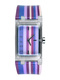

In [49]:
test_img = '/content/Fashion_data/categories/Accessories/10593.jpg'
dispImage(test_img)

In [22]:
#hide-output
styles = pd.read_csv('/content/styles.csv', on_bad_lines='skip')
styles['id'] = styles['id'].astype('str')
styles.to_csv('/content/styles.csv', index=False)

In [23]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [24]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [31]:
for findex, fname in tqdm(enumerate(allfiles)):
  # Load the data, it might have multiple rows
  file_vector = np.loadtxt(fname)

  # Check if the file_vector has more than one dimension or if it has the correct dimension
  if file_vector.ndim > 1 or file_vector.shape[0] != dims:
      # If it does, take the first 256 elements (assuming it contains the features)
      file_vector = file_vector[:dims]

  # Now ensure it's reshaped to the expected dimensions (dims=256)
  # file_vector = file_vector.reshape(dims) # This line is no longer necessary

  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

5000it [00:24, 207.47it/s]


In [32]:
#hide-output
t.build(trees)
t.save('t.ann')

True

In [35]:
#hide

if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

file_path = '/content/drive/MyDrive/ImgSim/'

In [36]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

# Step 5: Local Testing

In [38]:
#hide
from PIL import Image
import matplotlib.image as mpimg

In [ ]:
img_addr = 'https://bergersonjoias.vteximg.com.br/arquivos/ids/305537-900-900/Relogio-TAG-Heuer-Carrera-Chronograph.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.LANCZOS)
img

In [ ]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()